### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np

from mynn.neural_network import NeuralNetwork
from mynn.layers import Layer

from unsupervised_learning.algorithms import (MountainClustering,
                                            SubstractiveClustering,
                                            KMeans,
                                            FuzzCMeans,
                                            GaussianMixture)

from mynn.utils import train_model
from helper_functions.data_management import data_loading, joint_random_sampling
from helper_functions.plotting import color_plot, plot3d_dataset, plot_umap, plot_training_history, plot_embedding

### Auxiliary Functions


In [2]:
def create_autoencoder(num_features: int, num_hidden_units: int, learning_rate: float):

    autoenconder = NeuralNetwork(
        layers=[
            Layer(num_features, num_hidden_units, activation="sigmoid", include_bias=True),
            Layer(num_hidden_units, num_features, activation="sigmoid", include_bias=True),
        ],
        learning_rate=learning_rate,
        loss="cuadratic",
    )

    return autoenconder

def get_autoencoder_embedding(trained_autoencoder: NeuralNetwork, inputs: np.ndarray):

    autoencoder_layers = trained_autoencoder.layers
    encoding_layer = autoencoder_layers[0]

    return encoding_layer.forward(inputs)

### Data Loading

In [3]:
manip_category = 'wash_trade'
energy_threshold = 0.5
use_cone = False
root_path = os.path.dirname(os.getcwd())

manip_features = data_loading(root_path, manip_category, energy_threshold, use_cone)

### Visualization

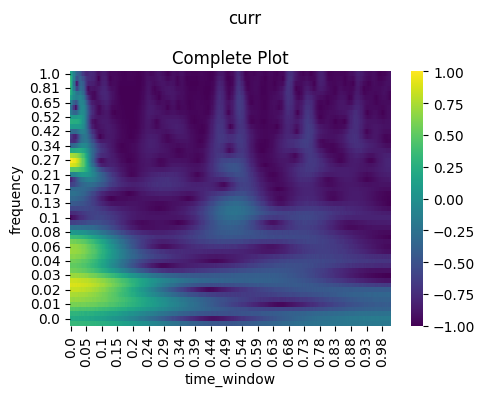

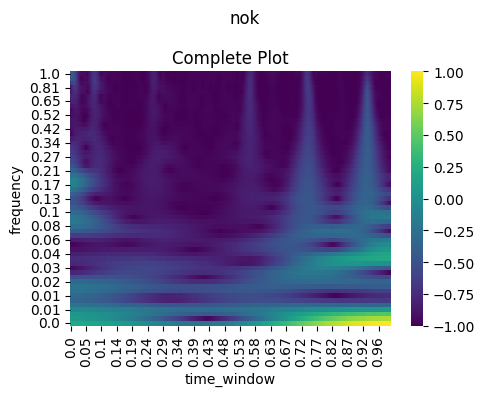

In [4]:
for stock_name, stock_dict in manip_features.items():
    color_plot(stock_dict, stock_name)

### Visualization

In [5]:
stock_name = 'nok'
plot_against = 'frequency'
hue_var = 'target'
feature_matrix = manip_features[stock_name]['features']

plot3d_dataset(feature_matrix, stock_name, plot_against, hue_var)

### Autoencoder

Epoch 1/3 | Loss: 0.058821618476401515
Epoch 2/3 | Loss: 0.058000495535567125
Epoch 3/3 | Loss: 0.05794810339584549


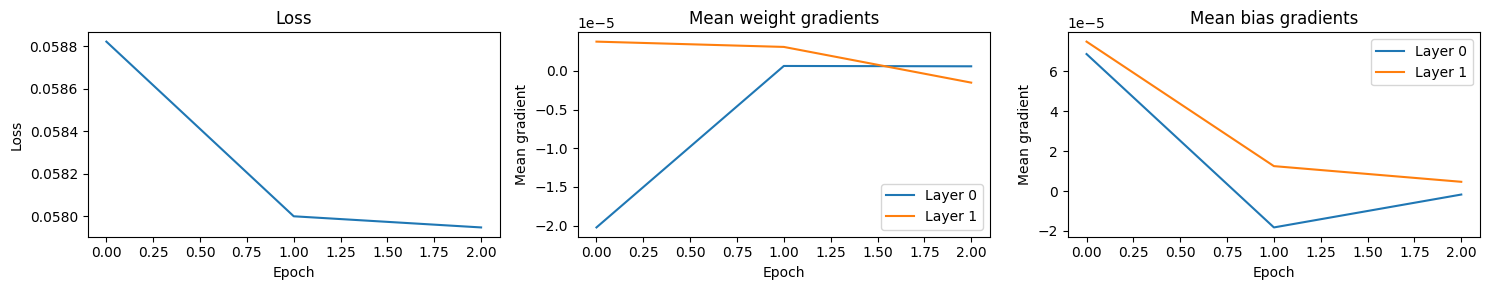

In [6]:
feature_matrices = [
    stock_dict['features'][:, :-1]
    for _, stock_dict in manip_features.items()
]

stacked_feature_matrix = np.vstack(feature_matrices)

autoencoder = create_autoencoder(num_features=stacked_feature_matrix.shape[1], num_hidden_units=3, learning_rate=1)

trained_autoencoder, train_history, _, _ = train_model(
    autoencoder, stacked_feature_matrix, stacked_feature_matrix, num_epochs=3, batch_size=1, verbose=True
)

plot_training_history(train_history, True, stacked_feature_matrix.shape[0])

### Sample Characteristics

In [7]:
total_n_samples = sum(len(stock_features['features']) for stock_features in manip_features.values())
percentage_to_sample = 10000 / total_n_samples
train_x_all, train_y, _, _, _, _ = joint_random_sampling(manip_features, percentage_to_sample, .01, 'uniform', False)

train_x = train_x_all[:, :-1]
train_modulus = train_x_all[:, -1].reshape(-1, 1)

### Visualize Sampled Data

In [8]:
plot_against = 'frequency'
hue_var = 'modulus'

plot3d_dataset(np.concatenate([train_x_all, train_y.reshape(-1, 1)], axis=1),
                f'{manip_category} - Sampled Dataset',
                plot_against,
                hue_var)

### Get embeddings

In [9]:
embedding = get_autoencoder_embedding(trained_autoencoder, train_x_all.T).T

plot_embedding(np.hstack([embedding, train_modulus, train_y.reshape(-1, 1)]),
                f'{manip_category} - Embedding Sampled Dataset',
                hue_modulus=True)

### Run Algorithms

#### Mountain Clustering

In [24]:
mountain_clustering = MountainClustering(number_of_partitions=10,
                                        distance_metric='euclidean',
                                        sigma_squared=1,
                                        beta_squared=1.5,)

mountain_clustering.fit(embedding)

mountain_cluster_assignments = mountain_clustering.predict()

mountain_feature_matrix = np.hstack([embedding, train_modulus, mountain_cluster_assignments])

In [27]:
plot_against = 'frequency'

plot_embedding(mountain_feature_matrix,
                f'{manip_category} - Embedding Mountain Clustering',
                hue_modulus=False)

#### Substractive Clustering

In [31]:
r_a = 1.1
substractive_clustering = SubstractiveClustering(r_a=r_a,
                                                r_b=1.5*r_a,
                                                distance_metric='euclidean',)
substractive_clustering.fit(embedding)
substractive_cluster_assignments = substractive_clustering.predict()
substractive_feature_matrix = np.hstack([embedding, train_modulus, substractive_cluster_assignments])

In [32]:
plot_embedding(substractive_feature_matrix,
                f'{manip_category} - Embedding Subtractive Clustering',
                hue_modulus=False)

### K-Means Clsustering

In [34]:
kmeans = KMeans(number_of_clusters=4,
                distance_metric='euclidean',
                n_iter=1000,
                verbose=False)
kmeans.fit(embedding)
kmeans_cluster_assignments = kmeans.predict()
kmeans_feature_matrix = np.hstack([embedding, train_modulus, kmeans_cluster_assignments.reshape(-1, 1)])

In [ ]:
plot_embedding(kmeans_feature_matrix,
                f'{manip_category} - Embedding KMeans Clustering',
                hue_modulus=False)

#### Fuzzy C Means

In [ ]:
fuzzycmeans = FuzzCMeans(number_of_clusters=5,
                        fuzzines_parameter=2,
                        distance_metric='euclidean',
                        n_iter=1000,
                        verbose=False,)
fuzzycmeans.fit(embedding)
fuzzycmeans_assignment_matrix = fuzzycmeans.predict()
fuzzycmeans_cluster_assignments = fuzzycmeans_assignment_matrix.argmax(axis=1).reshape(-1, 1)
fuzzycmeans_feature_matrix = np.hstack([embedding, train_modulus, fuzzycmeans_cluster_assignments])

In [66]:
plot_embedding(fuzzycmeans_feature_matrix,
                f'{manip_category} - Embedding Fuzzy C Means Clustering',
                hue_modulus=False)

#### Gaussian Mixture

In [71]:
expectation_maximization = GaussianMixture(number_of_clusters=5, n_iter=200)
expectation_maximization.fit(embedding)
gmm_assignment_matrix = expectation_maximization.predict()
gmm_cluster_assignments = gmm_assignment_matrix.argmax(axis=1).reshape(-1, 1)
gmm_feature_matrix = np.hstack([embedding, train_modulus, gmm_cluster_assignments])

In [72]:
plot_embedding(gmm_feature_matrix,
                f'{manip_category} - Embedding Gaussian Mixture Clustering',
                hue_modulus=False)